# Prepare Data


In [1]:
import pandas as pd

In [2]:
path= "/kaggle/input/nlp-data/problem_and_human_solutions_list_filtered_cleaned_with_complexities.jsonl"
# Load the JSONL file into a pandas DataFrame
df_phsl_cleaned = pd.read_json(path, lines=True)
df_phsl_cleaned.head()

,problem_id,problem_name,description,correct_solution_list
0,0,339_C. Xenia and Weights,Xenia has a set of weights and pan scales. Eac...,"[{'solution_id': '0_0', 'solution_code': '__au..."
1,1,1547_E. Air Conditioners,On a strip of land of length n there are k air...,"[{'solution_id': '1_0', 'solution_code': 'def ..."
2,2,268_C. Beautiful Sets of Points,Manao has invented a new mathematical term — a...,"[{'solution_id': '2_0', 'solution_code': 'if _..."
3,3,478_C. Table Decorations,"You have r red, g green and b blue balloons. T...","[{'solution_id': '3_0', 'solution_code': 'a = ..."
4,4,5_C. Longest Regular Bracket Sequence,This is yet another problem dealing with regul...,"[{'solution_id': '4_0', 'solution_code': 'stri..."


In [3]:
df_phsl_cleaned.shape

(3014, 4)

In [4]:
df_phsl_cleaned["correct_solution_list"][0][:2]

[{'solution_id': '0_0',
  'solution_code': '__author__ = \'ratnesh.mishra\'\n\nweights = map(int, input())\n\nweights = [cnt for cnt, x in enumerate(weights, 1) if x]\n\nm = int(input())\n\nstate = [(0, 0, 0, [])]\n\nres = "NO"\nwhile state:\n    w, b, k, l = state.pop()\n\n    if k == m:\n        res = \'YES\\n\' + \' \'.join(map(str, l))\n        break\n\n    for wt in weights:\n        if wt != w and wt > b:\n            state.append((wt, wt-b, k+1, l+[wt]))\n\nprint(res)\n\n',
  'time_complexity': 'O(1)',
  'space_complexity': 'O(n**2)'},
 {'solution_id': '0_2',
  'solution_code': "import sys\nsys.setrecursionlimit (1000000)\n\ntmp = list (map (int,(list(input()))))\nw = [i+1 for i in range (len (tmp)) if tmp[i] == 1]\nm = int (input ())\n\ndef dfs (b,p,s):\n  if s == m:\n    return [p]\n  for i in w:\n    if i != p and i > b:\n      ret = dfs (i-b,i,s+1)\n      if ret:\n        ret.append (p)\n        return ret\n  return None\n\nret = dfs (0,0,0)\nif ret:\n  print ('YES')\n  ret.

In [5]:
#!pip install transformers

In [6]:
import torch
import numpy as np

In [7]:
# Prepare a list to collect the flattened rows
flat_rows = []

# Loop over each problem
for _, row in df_phsl_cleaned.iterrows():
    problem_id = row["problem_id"]
    solutions = row["correct_solution_list"]

    # Each solution in the list
    for sol in solutions:
        flat_rows.append({
            "problem_id": problem_id,
            "solution_id": sol["solution_id"],
            "solution_code": sol["solution_code"],
            "time_complexity": sol["time_complexity"],
            "space_complexity": sol["space_complexity"]
        })

# Convert to a new DataFrame
flat_df = pd.DataFrame(flat_rows)

# Optional: drop rows with missing labels or code
flat_df = flat_df.dropna(subset=["solution_code", "time_complexity", "space_complexity"])

# Check result
flat_df.head()


,problem_id,solution_id,solution_code,time_complexity,space_complexity
0,0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,O(1),O(n**2)
1,0,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,O(1),O(1)
2,0,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,O(1),O(1)
3,0,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",O(1),O(1)
4,0,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",O(1),O(1)


In [8]:
flat_df.shape

(1041578, 5)

In [9]:
!pip install datasets
#!pip install --upgrade transformers

In [10]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix

2025-05-15 13:15:53.966100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747314953.985241   35660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747314953.991180   35660 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# You can choose CodeBERT or a similar model
MODEL_NAME = "microsoft/codebert-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
print("vocabulary size: ", len(tokenizer.vocab))

vocabulary size:  50265


In [13]:
#print(tokenizer.vocab)

In [14]:
code_sample = "def binary_search(arr, x): return -1"

# Tokenizzazione (con padding e truncation per sicurezza)
inputs = tokenizer(code_sample, return_tensors="pt", padding=True, truncation=True)

In [15]:
print("input text: "+ code_sample)
print("input tokenized ids: " + str(inputs.input_ids[0]))
print("tokenized: ", [tokenizer.decode(id) for id in inputs.input_ids[0]])

input text: def binary_search(arr, x): return -1
input tokenized ids: tensor([    0,  9232, 32771,  1215, 21061,  1640,  6166,     6,  3023,  3256,
          671,   111,   134,     2])
tokenized:  ['<s>', 'def', ' binary', '_', 'search', '(', 'arr', ',', ' x', '):', ' return', ' -', '1', '</s>']


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
time_classes= flat_df["time_complexity"].unique()
space_classes= flat_df["space_complexity"].unique()

In [18]:
print("Number of Time Classes labels: ", len(time_classes))
print("Number of Space Classes labels: ", len(space_classes))
print("Time Classes: ", time_classes[:20])#Only the first 20
print("Space Classes: ",space_classes[:20])#Only the first 20

Number of Time Classes labels:  439
Number of Space Classes labels:  262
Time Classes:  ['O(1)' 'O(n)' 'O(nlogn)' 'O(n**2)' 'O(n+m)' 'O(nlogn*m)' 'O(logn)'
 'O(n*m)' 'O(nlogn**2)' 'O(n*mlogm)' 'O(n*logm)' 'O(n+m**2)'
 'O(n+m)log(n+m)' 'O(nlogn+mlogm)+(k+l)' 'O(nlogn+m)' 'O(n+mlogm)'
 'O(n+(m+k))' 'O(nlogn+mlogm)' 'O((n+m)+k)' 'O(nlogn+(m+k))']
Space Classes:  ['O(n**2)' 'O(1)' 'O(n)' 'O(n+m)' 'O(n*m)' 'O(n*mlogm)' 'O(logn)'
 'O(n*m**2)' 'O(n**2*m)' 'O(nlogn)' 'O(logn*logm)' 'O((n+m)+k)' 'O(n+m+k)'
 'O((n**2)+m)' 'O(n+(m**2))' 'O(n+(m*k))' 'O(nlogn+m)' 'O(n**2+m)'
 'O(nlogn*m)' 'O(n+m**2)']


In [19]:
top_time_classes_labels = flat_df["time_complexity"].value_counts().nlargest(7).index.tolist()
top_time_classes_occurences = flat_df["time_complexity"].value_counts().nlargest(7).tolist()
print("Top 10 Time Complexities:")
for label, occ in zip(top_time_classes_labels, top_time_classes_occurences):
    print(f"{label}: {occ}")


Top 10 Time Complexities:
O(n): 432454
O(1): 231839
O(nlogn): 105453
O(n**2): 83171
O(n*m): 56610
O(n+m): 37593
O(logn): 19463


In [20]:
top_space_classes_labels = flat_df["space_complexity"].value_counts().nlargest(7).index.tolist()
top_space_classes_occurences = flat_df["space_complexity"].value_counts().nlargest(7).tolist()
print("Top 10 Space Complexities:")
for label, occ in zip(top_space_classes_labels, top_space_classes_occurences):
    print(f"{label}: {occ}")

Top 10 Space Complexities:
O(n): 537972
O(1): 294934
O(n*m): 55585
O(n**2): 37183
O(n+m): 34146
O(logn): 26314
O(nlogn): 14298


In [21]:
# Create a copy of flat_df to avoid modifying the original DataFrame
filtered_df = flat_df.copy()

# Apply the transformations as before
filtered_df["time_complexity"] = flat_df["time_complexity"].apply(
    lambda l: l if l in top_time_classes_labels else "Other"
)

filtered_df["space_complexity"] = flat_df["space_complexity"].apply(
    lambda l: l if l in top_space_classes_labels else "Other"
)

# Riassegna gli indici
filtered_df.reset_index(drop=True, inplace=True)

In [22]:
# Codifica per time_complexity
time_encoder = LabelEncoder()
filtered_df["time_label"] = time_encoder.fit_transform(filtered_df["time_complexity"])

# Codifica per space_complexity
space_encoder = LabelEncoder()
filtered_df["space_label"] = space_encoder.fit_transform(filtered_df["space_complexity"])


In [23]:
filtered_df[filtered_df["space_complexity"]=="Other"].head()

,problem_id,solution_id,solution_code,time_complexity,space_complexity,time_label,space_label
292,2,2_127,"n,m=list(map(int,input().split()))\nc=[]\ng=[]...",Other,Other,7,7
1059,8,8_77,"n = int(input())\na = list(map(int, input().sp...",O(nlogn),Other,6,7
1077,8,8_105,#_____________________________________________...,O(nlogn),Other,6,7
1164,8,8_247,def f(x):\n i = 0\n z = x\n while z %...,O(nlogn),Other,6,7
1191,8,8_295,"n = int(input())\na = list(map(int, input().sp...",O(nlogn),Other,6,7


# Time Complexity Classifier

In [24]:
full_unbalanced_df=filtered_df.copy()

## Light Training

In [25]:
# Imposta massimo per classe
max_per_class = 10000
# Prendi max_per_class esempi per ogni classe
filtered_df = (
    filtered_df
    .groupby("time_label", group_keys=False)  # eviti indici multi-livello
    .sample(n=max_per_class, random_state=42)           # riproducibilità con seed
    .reset_index(drop=True)
    .copy()# <-- Questo rende tutto indipendente
)


In [26]:
filtered_df.shape

(80000, 7)

In [27]:
filtered_df["time_label"].value_counts()

time_label
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
7    10000
Name: count, dtype: int64

In [28]:
time_encoded_labels = filtered_df["time_label"]
print(time_encoded_labels.value_counts())

id2label_time = {idx: label for idx, label in enumerate(time_encoder.classes_)}
label2id_time = {label: idx for idx, label in id2label_time.items()}
print(id2label_time)
print(label2id_time)

time_label
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
7    10000
Name: count, dtype: int64
{0: 'O(1)', 1: 'O(logn)', 2: 'O(n)', 3: 'O(n**2)', 4: 'O(n*m)', 5: 'O(n+m)', 6: 'O(nlogn)', 7: 'Other'}
{'O(1)': 0, 'O(logn)': 1, 'O(n)': 2, 'O(n**2)': 3, 'O(n*m)': 4, 'O(n+m)': 5, 'O(nlogn)': 6, 'Other': 7}


In [29]:
from sklearn.model_selection import train_test_split

# Suddivisione per time complexity
train_df_time, test_df_time = train_test_split(
    filtered_df,
    test_size=0.2,
    stratify=filtered_df["time_label"],
    random_state=42
)
'''
# Suddivisione per space complexity
train_df_space, test_df_space = train_test_split(
    filtered_df,
    test_size=0.2,
    stratify=filtered_df["space_label"],
    random_state=42
)'''

'\n# Suddivisione per space complexity\ntrain_df_space, test_df_space = train_test_split(\n    filtered_df,\n    test_size=0.2,\n    stratify=filtered_df["space_label"],\n    random_state=42\n)'

In [30]:
train_df_time, valid_df_time = train_test_split(
    train_df_time,
    test_size=0.2,
    stratify=train_df_time["time_label"],
    random_state=42
)
'''
train_df_space, valid_df_space = train_test_split(
    train_df_space,
    test_size=0.2,
    stratify=train_df_space["space_label"],
    random_state=42
)'''

'\ntrain_df_space, valid_df_space = train_test_split(\n    train_df_space,\n    test_size=0.2,\n    stratify=train_df_space["space_label"],\n    random_state=42\n)'

In [31]:
# Rimuove righe con codice sorgente mancante
train_df_time = train_df_time.dropna(subset=["solution_code"])
valid_df_time = valid_df_time.dropna(subset=["solution_code"])

# Normalizza il testo del codice sorgente
train_df_time["solution_code"] = train_df_time["solution_code"].apply(lambda x: x.strip())
valid_df_time["solution_code"] = valid_df_time["solution_code"].apply(lambda x: x.strip())


In [32]:
print("Train Shape: ", train_df_time.shape)
print("Valid Shape: ", valid_df_time.shape)
print("Test Shape: ", test_df_time.shape)

Train Shape:  (51200, 7)
Valid Shape:  (12800, 7)
Test Shape:  (16000, 7)


In [33]:
# Crea i dataset per time complexity
train_dataset_time = Dataset.from_pandas(train_df_time[["solution_code", "time_label"]])
val_dataset_time = Dataset.from_pandas(valid_df_time[["solution_code", "time_label"]])
test_dataset_time = Dataset.from_pandas(test_df_time[["solution_code", "time_label"]])


In [34]:
data = DatasetDict()
data['train'] = train_dataset_time
data['validation'] = val_dataset_time
data['test'] = test_dataset_time

In [35]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 51200
    })
    validation: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 12800
    })
    test: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 16000
    })
})


In [36]:
def tokenize_function(examples):
    return tokenizer(examples["solution_code"], padding=True, truncation=True)


In [37]:
tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/51200 [00:00<?, ? examples/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [38]:
tokenized_data["train"]

Dataset({
    features: ['solution_code', 'time_label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 51200
})

In [39]:
tokenized_data=tokenized_data.remove_columns("__index_level_0__")#present because of the pandas conversion

In [40]:
tokenized_data = tokenized_data.map(lambda x: {"label": x["time_label"]}, remove_columns=["time_label"])#rename the column

Map:   0%|          | 0/51200 [00:00<?, ? examples/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [41]:
tokenized_data["train"][0].keys()

dict_keys(['solution_code', 'input_ids', 'attention_mask', 'label'])

In [42]:

print("Max len: ",len(tokenized_data["train"][0]["input_ids"]))
print("Time label: ", tokenized_data["train"][0]["label"])
print("Tokenized data: ",tokenized_data["train"][0]["input_ids"])

Max len:  512
Time label:  6
Tokenized data:  [0, 282, 5457, 6979, 1640, 46797, 49338, 50118, 9119, 29, 5457, 24713, 1640, 8458, 1640, 32557, 1640, 2544, 6, 8135, 49123, 44154, 43048, 47619, 50118, 9119, 29, 5457, 5456, 1640, 6031, 6, 11311, 29, 43, 50118, 17265, 45803, 48694, 26960, 1640, 9119, 29, 35122, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [43]:
print(tokenizer.decode(tokenized_data["train"][0]["input_ids"])) #just have a look to the decoded soluton from input_ids

<s>n = int(input())
cols = sorted(list(map(int, input().split())))
cols = map(str, cols)
print(' '.join(cols))</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

### Training CodeBert Model

In [44]:
from transformers import RobertaModel, RobertaPreTrainedModel, RobertaConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Numero di classi
num_labels = len(time_encoder.classes_)
print("Number of Classes: ", num_labels)

# Nome del modello preaddestrato
model_name = "microsoft/codebert-base"

# Modello con classificazione (es. n classi)
time_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
print(time_model)

Number of Classes:  8


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassific

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [46]:
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return total_params, trainable_params

# Esegui la funzione sul tuo modello
count_trainable_parameters(time_model)

Total parameters: 124,651,784
Trainable parameters: 124,651,784


(124651784, 124651784)

In [47]:
'''for name, param in time_model.roberta.named_parameters():
    if "layer" in name:
        # Sblocca gli ultimi 2-4 layer (ad esempio)
        layer_number = int(name.split('.')[2])  # Estrai il numero del layer
        if layer_number >= 7:  # Sblocca layer da 10 in poi
            param.requires_grad = True
        else:
            param.requires_grad = False
    elif "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # Congela altri parametri'''

'for name, param in time_model.roberta.named_parameters():\n    if "layer" in name:\n        # Sblocca gli ultimi 2-4 layer (ad esempio)\n        layer_number = int(name.split(\'.\')[2])  # Estrai il numero del layer\n        if layer_number >= 7:  # Sblocca layer da 10 in poi\n            param.requires_grad = True\n        else:\n            param.requires_grad = False\n    elif "pooler" in name:\n        param.requires_grad = True\n    else:\n        param.requires_grad = False  # Congela altri parametri'

In [48]:
count_trainable_parameters(time_model)

Total parameters: 124,651,784
Trainable parameters: 124,651,784


(124651784, 124651784)

In [49]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [50]:
import transformers
print(transformers.__version__)

4.28.0


In [51]:
#!pip uninstall transformers -y
!pip install transformers==4.28.0
from transformers import TrainingArguments

In [52]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    evaluation_strategy="steps",      # Valuta ogni X step
    save_strategy="steps",            # Salva ogni X step
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,          # Eval loss → più basso è meglio
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    fp16=True,
    report_to="none"
)


In [53]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [54]:
trainer = Trainer(
    model=time_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:645: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
trainer.train()

In [ ]:
# Salva il modello
model_path = '/kaggle/working/codebert_large_finetuned'  # Percorso dove salvare il modello
time_model.save_pretrained(model_path)
# Salva anche il tokenizer (per usarlo successivamente)
tokenizer.save_pretrained(model_path)


In [ ]:
!zip -r codbert_large_finetuned.zip /kaggle/working/codebert_large_finetuned

### CodeBert Model Evaluation

In [62]:
time_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [63]:
preds = trainer.predict(tokenized_data['test'])
preds

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


PredictionOutput(predictions=array([[-2.150e+00, -2.439e+00,  3.030e-01, ...,  4.734e+00, -2.671e-01,
         2.564e+00],
       [ 4.727e+00,  3.561e+00, -4.987e-02, ..., -3.275e+00,  1.968e-01,
        -1.975e+00],
       [ 3.395e+00,  5.742e+00,  1.343e+00, ..., -3.607e+00, -1.221e+00,
        -3.027e+00],
       ...,
       [-1.610e+00, -9.648e-01,  5.414e-02, ..., -1.556e+00,  7.230e+00,
        -1.588e+00],
       [-3.822e+00, -2.119e+00,  2.400e+00, ..., -1.212e+00, -2.246e+00,
         4.062e+00],
       [-4.195e+00, -3.846e+00, -5.938e-01, ..., -6.199e-03,  2.984e+00,
         4.320e+00]], dtype=float16), label_ids=array([5, 0, 1, ..., 6, 7, 5]), metrics={'test_loss': 0.8397120237350464, 'test_accuracy': 0.7259375, 'test_precision': 0.728879584257842, 'test_recall': 0.7259375, 'test_f1': 0.7250330459910085, 'test_runtime': 121.0638, 'test_samples_per_second': 132.162, 'test_steps_per_second': 4.13})

In [65]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred.shape

(16000,)

In [66]:
label_names = time_encoder.classes_
print(label_names)
test_target= tokenized_data["test"]["label"]
test_target= np.array(test_target)
print(test_target.shape)

['O(1)' 'O(logn)' 'O(n)' 'O(n**2)' 'O(n*m)' 'O(n+m)' 'O(nlogn)' 'Other']
(16000,)


In [ ]:
print(classification_report(test_target, y_pred, target_names=label_names))

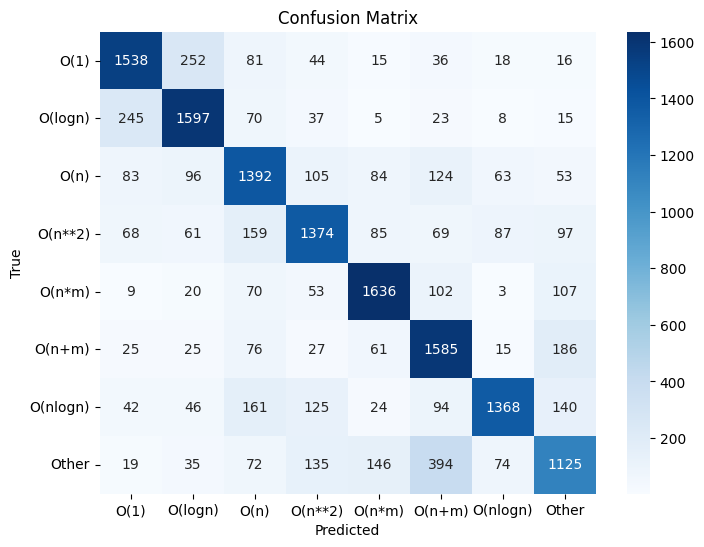

In [68]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_target, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=time_encoder.classes_, yticklabels=time_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Refine FineTuning

In [56]:
#Load the model already finetuned for further processing 
model_path="/kaggle/working/codebert_large_finetuned"
time_model=AutoModelForSequenceClassification.from_pretrained(model_path)

In [57]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    evaluation_strategy="steps",      # Valuta ogni X step
    save_strategy="steps",            # Salva ogni X step
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,          # Eval loss → più basso è meglio
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    learning_rate=5e-5,#learning rate piu basso 
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    fp16=True,
    report_to="none"
)


In [59]:
trainer = Trainer(
    model=time_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

In [60]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.377700,1.038536,0.708203,0.708668,0.708203,0.706601
1000,0.434500,1.036619,0.702109,0.703653,0.702109,0.701700
1500,0.675900,0.871259,0.719219,0.723409,0.719219,0.718345
2000,0.576700,0.887584,0.721875,0.721578,0.721875,0.720966
2500,0.534300,0.907762,0.716953,0.718118,0.716953,0.716573
3000,0.503400,0.872567,0.723984,0.727830,0.723984,0.725043


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3000, training_loss=0.5005478871663411, metrics={'train_runtime': 2795.7703, 'train_samples_per_second': 146.507, 'train_steps_per_second': 4.578, 'total_flos': 2.5260022038528e+16, 'train_loss': 0.5005478871663411, 'epoch': 1.88})

In [61]:
# Salva il modello
model_path = '/kaggle/working/codebert_large_finetuned_2'  # Percorso dove salvare il modello
time_model.save_pretrained(model_path)
# Salva anche il tokenizer (per usarlo successivamente)
tokenizer.save_pretrained(model_path)

('/kaggle/working/codebert_large_finetuned_2/tokenizer_config.json',
 '/kaggle/working/codebert_large_finetuned_2/special_tokens_map.json',
 '/kaggle/working/codebert_large_finetuned_2/vocab.json',
 '/kaggle/working/codebert_large_finetuned_2/merges.txt',
 '/kaggle/working/codebert_large_finetuned_2/added_tokens.json',
 '/kaggle/working/codebert_large_finetuned_2/tokenizer.json')

In [69]:
!zip -r codbert_large_finetuned_2.zip /kaggle/working/codebert_large_finetuned_2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/codebert_large_finetuned_2/ (stored 0%)
  adding: kaggle/working/codebert_large_finetuned_2/pytorch_model.bin (deflated 7%)
  adding: kaggle/working/codebert_large_finetuned_2/config.json (deflated 55%)
  adding: kaggle/working/codebert_large_finetuned_2/tokenizer.json (deflated 72%)
  adding: kaggle/working/codebert_large_finetuned_2/vocab.json (deflated 59%)
  adding: kaggle/working/codebert_large_finetuned_2/tokenizer_config.json (deflated 81%)
  adding: kaggle/working/codebert_large_finetuned_2/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/codebert_large_finetuned_2/merges.txt (deflated 53%)
